<a href="https://colab.research.google.com/github/Tien84/Face-Detection/blob/master/Grid_Search_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/driver')

Mounted at /content/driver


(2558, 6)


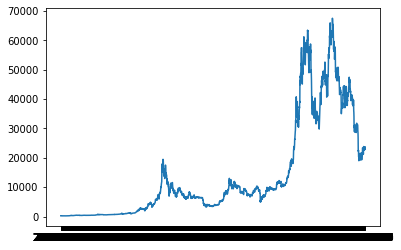

In [ ]:
# load and plot dataset
from pandas import read_csv
from matplotlib import pyplot
# load
series = read_csv('/content/driver/My Drive/LSTM_Model/DataBitcoin.csv', header=0, index_col=0)
# summarize shape
print(series.shape)
# plot
pyplot.plot(series['Adj Close'])
pyplot.show()

In [ ]:
# grid search cnn for airline passengers
from math import sqrt
from numpy import array
from numpy import mean
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test], data[-n_test:]
 
# transform list into supervised learning format
def series_to_supervised(data, n_in=1, n_out=1):
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	agg.dropna(inplace=True)
	return agg.values
 
# root mean squared error or rmse
def measure_rmse(actual, predicted):
	return sqrt(mean_squared_error(actual, predicted))
# mape
def measure_mape(test, predicted):
  return mean(abs(array(predicted) - array(test))/abs(test))
# difference dataset
def difference(data, order):
	return [data[i] - data[i - order] for i in range(order, len(data))]
 

In [ ]:
# fit a model
def model_fit(train, config):
	# unpack config
	n_input, n_filters, n_kernel, n_epochs, n_batch, n_diff = config
	# prepare data
	if n_diff > 0:
		train = difference(train, n_diff)
	# transform series into supervised format
	data = series_to_supervised(train, n_in=n_input)
	# separate inputs and outputs
	train_x, train_y = data[:, :-1], data[:, -1]
	# reshape input data into [samples, timesteps, features]
	n_features = 1
	train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], n_features))
	# define model
	model = Sequential()
	model.add(Conv1D(filters=n_filters, kernel_size=n_kernel, activation='relu', input_shape=(n_input, n_features)))
	model.add(MaxPooling1D(pool_size=2))
	model.add(Flatten())
	model.add(Dense(1))
	model.compile(loss='mse', optimizer='adam')
	# fit
	model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
	return model

In [ ]:
# forecast with the fit model
def model_predict(model, history, config):
	# unpack config
	n_input, _, _, _, _, n_diff = config
	# prepare data
	correction = 0.0
	if n_diff > 0:
		correction = history[-n_diff]
		history = difference(history, n_diff)
	x_input = array(history[-n_input:]).reshape((1, n_input, 1))
	# forecast
	yhat = model.predict(x_input, verbose=0)
	return correction + yhat[0]

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_rmse(test, predictions)
	print(' > %.3f' % error)
	return error

In [ ]:
# walk-forward validation for univariate data
def walk_forward_validation_mape(data, n_test, cfg):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# fit model
	model = model_fit(train, cfg)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# fit model and make forecast for history
		yhat = model_predict(model, history, cfg)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
	# estimate prediction error
	error = measure_mape(test, predictions)
	print(' > %.3f' % error)
	return error

In [ ]:
# score a model, return None on failure
def repeat_evaluate(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)

In [ ]:
# score a model, return None on failure
def repeat_evaluate_mape(data, config, n_test, n_repeats=10):
	# convert config to a key
	key = str(config)
	# fit and evaluate the model n times
	scores = [walk_forward_validation_mape(data, n_test, config) for _ in range(n_repeats)]
	# summarize score
	result = mean(scores)
	print('> Model[%s] %.3f' % (key, result))
	return (key, result)

In [ ]:
# grid search configs
def grid_search(data, cfg_list, n_test):
	# evaluate configs
	scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

In [ ]:
# grid search configs
def grid_search_mape(data, cfg_list, n_test):
	# evaluate configs
	scores = [repeat_evaluate_mape(data, cfg, n_test) for cfg in cfg_list]
	# sort configs by error, asc
	scores.sort(key=lambda tup: tup[1])
	return scores

In [ ]:
# create a list of configs to try
def model_configs():
	# define scope of configs
	n_input = [12]
	n_filters = [50]
	n_kernels = [3, 5]
	n_epochs = [20]
	n_batch = [1, 30]
	n_diff = [12]
	# create configs
	configs = list()
	for a in n_input:
		for b in n_filters:
			for c in n_kernels:
				for d in n_epochs:
					for e in n_batch:
						for f in n_diff:
							cfg = [a,b,c,d,e,f]
							configs.append(cfg)
	print('Total configs: %d' % len(configs))
	return configs

In [ ]:
# define dataset
series = read_csv('/content/driver/My Drive/LSTM_Model/DataBitcoin.csv', header=0, index_col=0)
data = series['Adj Close'].values
# data split
n_test = 768
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
scores_mape = grid_search_mape(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:10]:
	print(cfg, error)
for cfg, error in scores_mape[:10]:
	print(cfg, error)

Total configs: 4
 > 0.754
 > 0.782
 > 0.749
 > 0.759
 > 0.789
 > 0.768
 > 0.758
 > 0.744
 > 0.767
 > 0.772
> Model[[12, 50, 3, 20, 1, 12]] 0.764
 > 0.763
 > 0.758
 > 0.766
 > 0.766
 > 0.769
 > 0.761
 > 0.761
 > 0.755
 > 0.761
 > 0.762
> Model[[12, 50, 3, 20, 30, 12]] 0.762
 > 0.758
 > 0.764
 > 0.763
 > 0.761
 > 0.756
 > 0.762
 > 0.769
 > 0.762
 > 0.776
 > 0.777
> Model[[12, 50, 5, 20, 1, 12]] 0.765
 > 0.763
 > 0.764
 > 0.753
 > 0.759
 > 0.758
 > 0.769
 > 0.763
 > 0.759
 > 0.757
 > 0.760
> Model[[12, 50, 5, 20, 30, 12]] 0.760
done
[12, 50, 5, 20, 30, 12] 0.7604409375664587
[12, 50, 3, 20, 30, 12] 0.7622852012334997
[12, 50, 3, 20, 1, 12] 0.7642604359095988
[12, 50, 5, 20, 1, 12] 0.7649500005043887
